# ***Notes:***

### ***Facebook Prophet Library:***
* [Facebook/Meta Prophet Docs](https://facebook.github.io/prophet/docs/quick_start)
* [What is FB Prophet?](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)
* FB Prophet plot explanations w/ examples:
  * [Example 1 - TDS](https://towardsdatascience.com/facebook-prophet-for-time-series-forecasting-in-python-part1-d9739cc79b1d)
  * [Example 2 - Blog](https://www.mikulskibartosz.name/prophet-plot-explained/)

### ***To-Do:***
* *(01/24/2022):*
  * Add block to remove outliers and see what happens to forecast(s)
  * Brainstorm additional regressors to add (if any)
  * Write script to automatically update at routine interval (i.e. daily)

### ***About:***
**Author**: Jordan Eisinger, Data Scientist \
**Created On**: 01/01/2023 \
**Last Updated On**: 03/16/2023

# ***Install & Import Libraries***
___

In [2]:
# pip install prophet

In [5]:
# pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandas.io.sql as sqlio # Reads SQL query or database atable in a DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, datetime
from prophet import Prophet
import json
import psycopg2
import itertools
from IPython.display import display, Markdown

Importing plotly failed. Interactive plots will not work.


# ***Setup & Test Database Connection***
___

In [4]:
# Opens AWS credentials stored in JSON object
with open('.creds.json',"r") as f:
    # Assigns dictionary varibale for credentials as JSON object
    creds = json.loads(f.read())
    
# Define connection object
# '**' passes arguments in the entire dictionary
conn = psycopg2.connect(**creds)

# Create cursor object
# Needed to execute PostgresSQL commands
try:
    with conn.cursor() as curs:
        # Test String query
        query = 'SELECT * FROM seeking_arrange.profiles WHERE id = 34601598 LIMIT 5'
        # Execute query
        curs.execute(query)
        # Print results
        for record in curs:
            print(record)
finally:
    # Closes connection
    conn.close()

(34601598, 31, 'ca4036b2-7f14-408f-9af7-c85954cb2beb', 34602929, 1, 34602555, 'generous', 'Male', '{"account_type":[{"id":"1","value":"generous"}],"sex":[{"id":"3","value":"Male"}],"education":[{"id":"9","value":"Graduate Degree"}],"relationship_status":[{"id":"14","value":"Single"}],"children":[{"id":"20","value":"0"}],"smoking":[{"id":"27","value":"Non Smoker"}],"drinking":[{"id":"31","value":"Social Drinker"}],"income":[{"id":"39","value":"300000"}],"net_worth":[{"id":"46","value":"500000"}],"hair_color":[{"id":"65","value":"Light Brown"}],"height":[{"id":"92","value":"191"}],"body_type":[{"id":"103","value":"Athletic"}],"ethnicity":[{"id":"115","value":"White \\/ Caucasian"}],"birthday_month":[{"id":"127","value":"May"}],"birthday_day":[{"id":"161","value":"28"}],"birthday_year":[{"id":"244","value":"1994"}],"gender_preference":[{"id":"249","value":"female"}],"language":[{"id":"250","value":"English"}],"seeking_tags":[{"id":"440","value":"Active lifestyle"},{"id":"446","value":"Fle

# ***Declare Functions***
___

In [56]:
# Opens AWS credentials stored in JSON object
with open('.creds.json',"r") as f:
    # Assigns dictionary varibale for credentials as JSON object
    creds = json.loads(f.read())

# Fucntion to execute SQl queries
def execute_rs_query_to_df(query=str,data=None):
    '''
    Establish database connection, execute SQL query and write output into a Pandas DataFrame.
            Parameters:
                    query (str): A string for the SQL query to be executed
                    data (None): Parameters to pass (None)
    '''
    try:
        # Define database connection object and pass entire dictionary
        conn = psycopg2.connect(**creds)
        # Execute SQL query into a DataFrame
        return sqlio.read_sql_query(query,conn,params=data)
    finally:
        # Close connection
        conn.close()

In [ ]:
# Define function to clean dataframe
def clean_data(d):
    '''
    Clean Pandas DataFrame: Drop first and last row, remove timestamp.
            Parameters:
                    d (Any): A Pandas DataFrame
            Returns:        
                    d (DataFrame): A Pandas DataFrame formatted correctly for FB Prophet model
    '''
    # Drop first row
    d = d.drop(0)
    # Drop last row
    d = d.drop(max(d.index))
    # Remove timestamp from first column
    d['ds'] = pd.to_datetime(d['ds'].dt.date)
    # Return DataFrame in correct format
    return d

In [62]:
# Define function to calculate number of days to forecast
def get_forecasting_period(beg=str,end=str):
    '''
    Return the number of days to forecast into the future based on input dates.
            Parameters:
                    beg (str): A string for the beginning of the forecast period
                    end (str): A string for the end of the forecast period
            Returns:
                    days (int): Integer of days to forecast into the future
    '''
    # Import datetime package
    import datetime

    # Converts date into correct format
    d1 = datetime.datetime.strptime(beg,"%Y/%m/%d")
    d2 = datetime.datetime.strptime(end,"%Y/%m/%d")

    # Calculates the number of days to forecast
    days = (d2 - d1).days
    
    # Return number of days to forecast as an integer 
    return days

# ***All U2P Forecasts***
___

## **Define Forecasting Period**

In [79]:
# Define forecast start and end dates
start_date = date.today().strftime("%Y/%m/%d") # Current day
end_date = '2023/12/31'

# Call function and assign output to variable
period = get_forecasting_period(start_date,end_date)
period

290

## **Total U2P Net Revenue**

In [68]:
# Net revenue query
net_rev_query = '''
-- Get rid of test processor payments
WITH u2p_test_processor_payments_dt AS (
  SELECT DISTINCT payment_id
  FROM u2p_sites.response_data
  WHERE 1=1
    AND response_data LIKE '%Test Processor%'
)
-- Net Revenue
SELECT
    DATE_TRUNC('day', pl.created_at AT TIME ZONE 'america/los_angeles') AS ds,
    SUM(pl.amount_usd) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
LEFT JOIN u2p_test_processor_payments_dt AS t ON t.payment_id = p.id
WHERE 1=1
    AND pl.created_at >= '2018-01-01'
    -- AND p.site_id IN (1,12)
    AND t.payment_id IS NULL
GROUP BY 1
ORDER BY 1
'''

In [80]:
# Call function to execute SQL query
df = execute_rs_query_to_df(net_rev_query)

# Call function to clean DataFrame
clean_data(df)

/var/folders/dc/rhdj5x955qb0m2r34vvqdlg40000gq/T/ipykernel_48101/748776041.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(query,conn,params=data)


ds          y
1    2018-01-01  151891.64
2    2018-01-02  185149.67
3    2018-01-03  168444.56
4    2018-01-04  166903.49
5    2018-01-05  141701.41
...         ...        ...
1896 2023-03-11  237703.62
1897 2023-03-12  240058.95
1898 2023-03-13  250886.04
1899 2023-03-14  247798.50
1900 2023-03-15  295694.01

[1900 rows x 2 columns]

In [97]:
# Instantiate Prophet object
model = Prophet()

# Call fit method
model.fit(df)
# --> The above sometimes returns an error, here is a possible reason why: https://stackoverflow.com/questions/73255165/library-not-loaded-rpath-libtbb-dylib-in-prophet-python
# --> Error seems to have been fixed usng method described here: https://github.com/facebook/prophet/issues/2250

# Create new dataframe that extends into the future a set number of days
future = model.make_future_dataframe(periods=period)

# Use predict method for future dates
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2187 2023-12-27  235974.421929  206169.225185  264321.633844
2188 2023-12-28  235961.650178  209156.736650  264366.729583
2189 2023-12-29  238566.043500  209470.466544  266882.450534
2190 2023-12-30  233118.679999  205244.085383  260735.064420
2191 2023-12-31  240547.399399  214339.745102  268139.813225

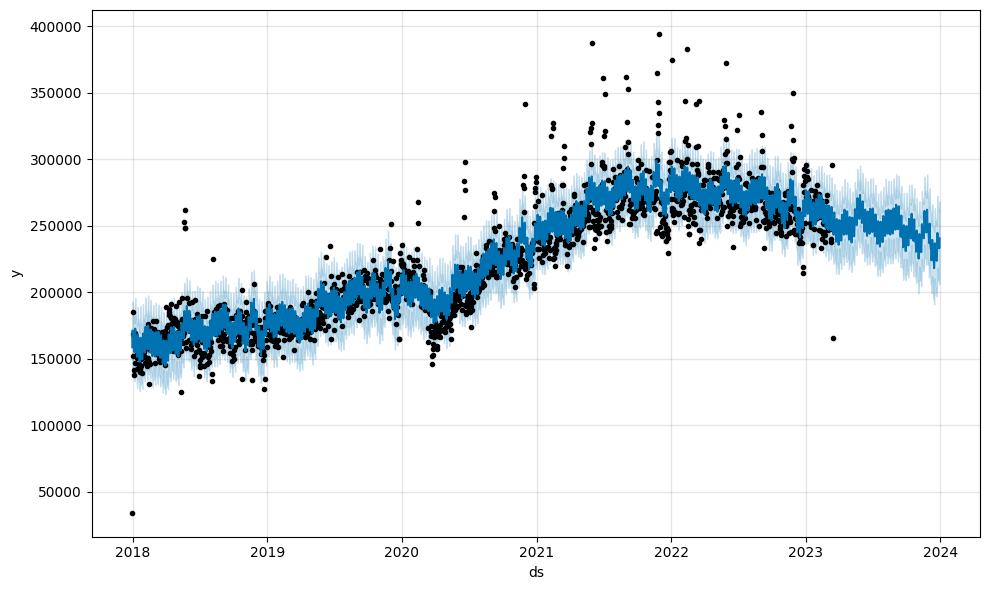

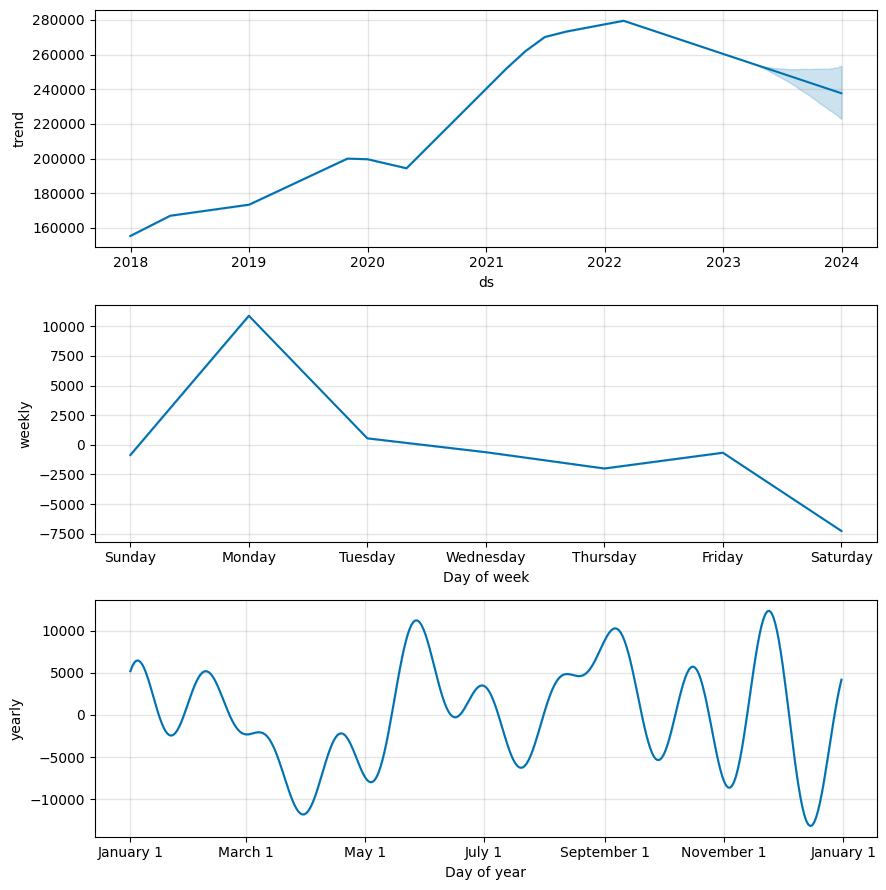

In [82]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [96]:
# 2023 prediction ranges
print("LOWER (NET):", sum(forecast[forecast.ds > '2022-12-31'].yhat_lower))
print("MIDDLE (NET):", sum(forecast[forecast.ds > '2022-12-31'].yhat))
print("UPPER (NET):", sum(forecast[forecast.ds > '2022-12-31'].yhat_upper))

LOWER (NET): 9753328.79138407
MIDDLE (NET): 11638004.662756832
UPPER (NET): 13541348.231612375


## **Non-SEM Net Revenue**

In [84]:
# Non-SEM net revenue query
non_sem_query = '''
-- Get rid of test processor payments
WITH u2p_test_processor_payments_dt AS (
  SELECT
    DISTINCT payment_id
  FROM u2p_sites.response_data
  WHERE 1=1
    AND response_data LIKE '%Test Processor%'
)
SELECT
  DATE_TRUNC('day', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS ds,
  -- SUM(CASE WHEN sap.id IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS b ON b.id = pl.payment_id
LEFT JOIN u2p_test_processor_payments_dt AS t ON t.payment_id = b.id
INNER JOIN u2p_sites.customers AS c ON c.id = b.customer_id
-- Non-SEM Seeking revenue
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.user_id = c.account_id
  AND b.site_id = 1
  AND NOT (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
-- Non-SEM WYP revenue
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id
  AND b.site_id = 12
  AND NOT (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.profiles AS wypp ON wypp.account_id = wypa.id
WHERE 1=1
  AND pl.created_at >= '2017-12-31 08:00:00' 
  AND t.payment_id IS NULL
GROUP BY 1
ORDER BY 1
'''

In [85]:
# Call function to execute SQL query
df_2 = execute_rs_query_to_df(non_sem_query)

# Call function to clean DataFrame
clean_data(df_2)

/var/folders/dc/rhdj5x955qb0m2r34vvqdlg40000gq/T/ipykernel_48101/748776041.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(query,conn,params=data)


ds          y
1    2018-01-01  130703.04
2    2018-01-02  161002.11
3    2018-01-03  146421.93
4    2018-01-04  143962.87
5    2018-01-05  122393.00
...         ...        ...
1896 2023-03-11  198549.94
1897 2023-03-12  201358.15
1898 2023-03-13  215896.92
1899 2023-03-14  207336.03
1900 2023-03-15  248680.61

[1900 rows x 2 columns]

In [86]:
# Instantiate Prophet object
model = Prophet()
# Call fit method
model.fit(df_2)

# Create new dataframe that extends into the future set number of periods
future = model.make_future_dataframe(periods=period)
future.tail()

# Use predict method for dates in the future
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2187 2023-12-27  204430.323328  181600.893208  227361.676491
2188 2023-12-28  204172.443639  180539.217389  225679.942524
2189 2023-12-29  206241.399712  183381.794762  227997.642568
2190 2023-12-30  201344.666535  179146.454768  225224.518380
2191 2023-12-31  208109.308453  185075.573693  230417.773067

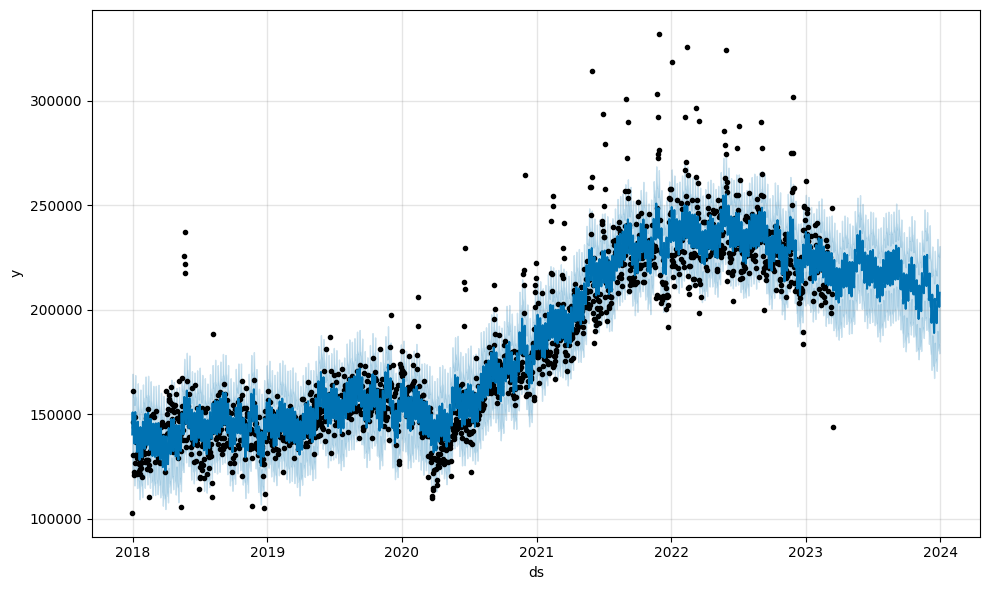

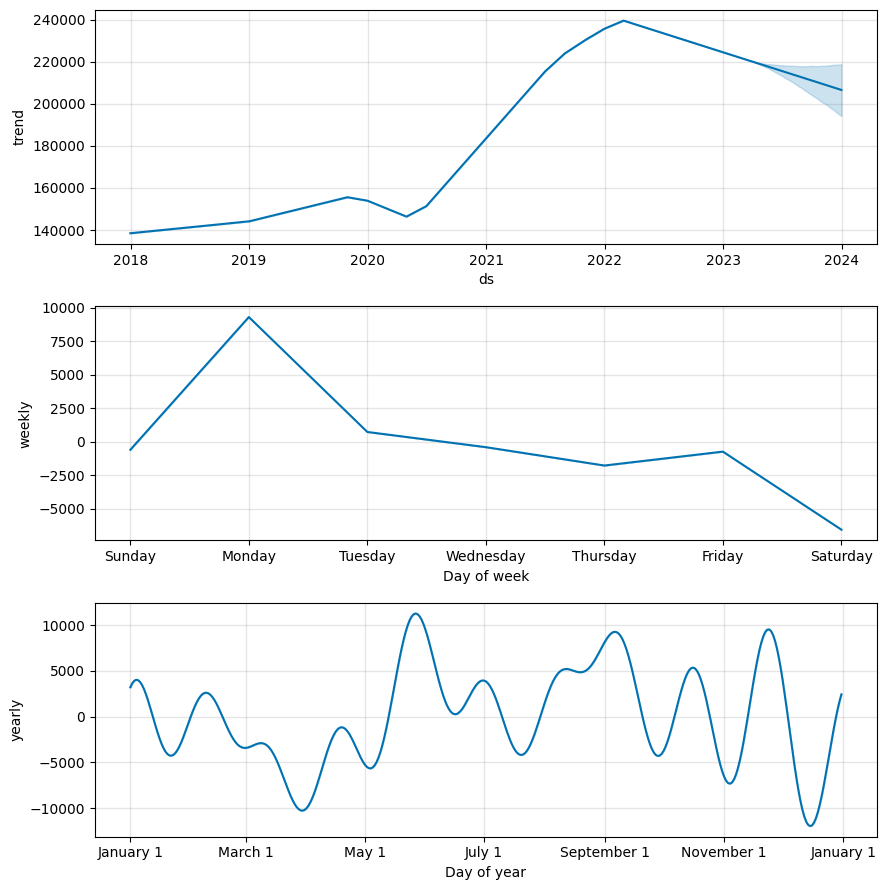

In [87]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [88]:
# 2023 prediction ranges
print("LOWER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_lower))
print("MIDDLE:", sum(forecast[forecast.ds > '2022-12-31'].yhat))
print("UPPER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_upper))

LOWER: 71694070.93846275
MIDDLE: 78681796.7426384
UPPER: 85691685.93452802


## **SEM Net Revenue < 2023**

In [89]:
# SEM net revenue query
sem_query = '''
-- Get rid of test processor payments
WITH u2p_test_processor_payments_dt AS (
  SELECT
    DISTINCT payment_id
  FROM u2p_sites.response_data
  WHERE 1=1
    AND response_data LIKE '%Test Processor%'
)
SELECT
  DATE_TRUNC('day', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS ds,
  -- SUM(CASE WHEN sap.id IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS b ON b.id = pl.payment_id
LEFT JOIN u2p_test_processor_payments_dt AS t ON t.payment_id = b.id
INNER JOIN u2p_sites.customers AS c ON c.id = b.customer_id
-- Non-SEM Seeking revenue
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.user_id = c.account_id
  AND b.site_id = 1
  AND (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
-- Non-SEM WYP revenue
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id
  AND b.site_id = 12
  AND (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.profiles AS wypp ON wypp.account_id = wypa.id
WHERE 1=1
  AND pl.created_at >= '2017-12-31 08:00:00' 
  AND t.payment_id IS NULL
GROUP BY 1
ORDER BY 1
'''

In [90]:
# Call function to execute SQL query
df_3 = execute_rs_query_to_df(sem_query)

# Call function to clean DataFrame
clean_data(df_3)

/var/folders/dc/rhdj5x955qb0m2r34vvqdlg40000gq/T/ipykernel_48101/748776041.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(query,conn,params=data)


ds         y
1    2018-01-01  19355.49
2    2018-01-02  21841.79
3    2018-01-03  20032.36
4    2018-01-04  20693.97
5    2018-01-05  16927.92
...         ...       ...
1896 2023-03-11  37995.20
1897 2023-03-12  37447.79
1898 2023-03-13  33262.30
1899 2023-03-14  39461.72
1900 2023-03-15  45472.77

[1900 rows x 2 columns]

In [91]:
# Instantiate Prophet object
model = Prophet()
# Call fit method
model.fit(df_3)

# Create new dataframe that extends into the future set number of periods
future = model.make_future_dataframe(periods=period)
future.tail()

# Use predict method for dates in the future
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:57:39 - cmdstanpy - INFO - Chain [1] start processing
15:57:39 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
2187 2023-12-27  29585.495945  23089.632694  36512.403791
2188 2023-12-28  29867.013355  23696.129562  36399.652539
2189 2023-12-29  30367.488354  24073.870066  37218.135161
2190 2023-12-30  29759.121368  23394.857977  36046.332868
2191 2023-12-31  30636.492581  24262.488359  37613.417059

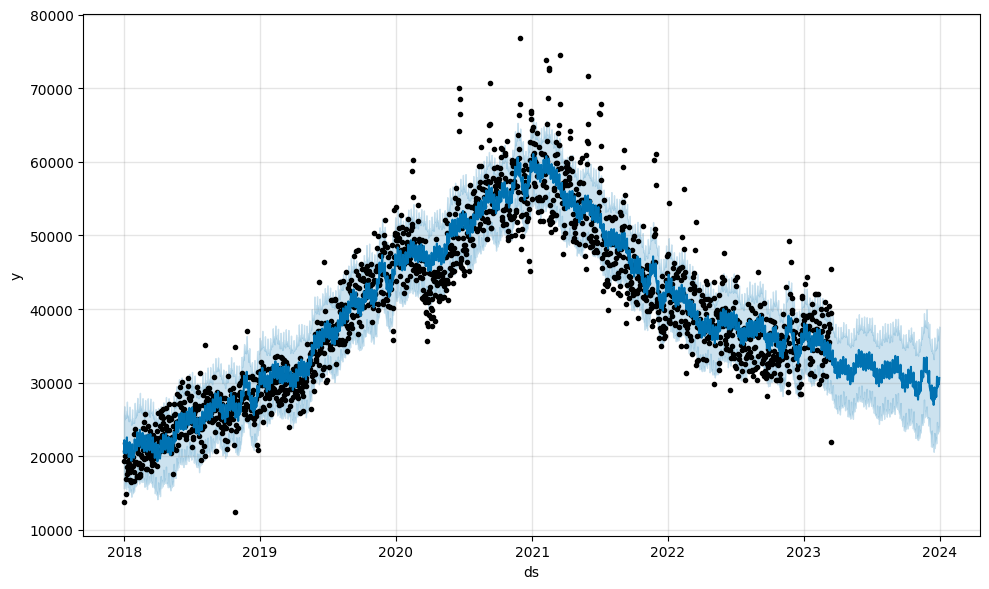

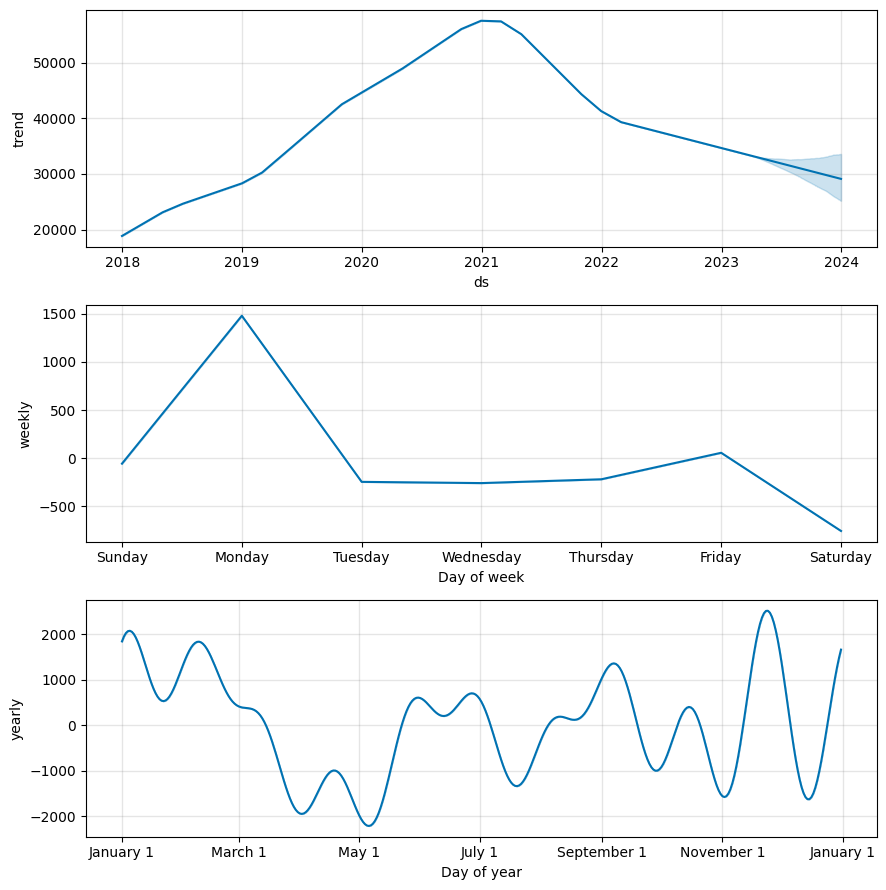

In [92]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [93]:
# 2023 prediction ranges
print("LOWER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_lower))
print("MIDDLE:", sum(forecast[forecast.ds > '2022-12-31'].yhat))
print("UPPER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_upper))

LOWER: 9753328.79138407
MIDDLE: 11638004.662756832
UPPER: 13541348.231612375


# **Promo Day Binary Variables**

In [98]:
# Add promo day regressor
promos = pd.Series([
    '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', 
    '2020-02-16', '2020-03-17', '2020-03-18', '2020-03-19', 
    '2020-03-20', '2020-03-21', '2020-06-18', '2020-06-19', 
    '2020-06-20', '2020-06-21', '2020-06-22', '2020-09-07', 
    '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', 
    '2020-09-12', '2020-11-25', '2020-11-26', '2020-11-27', 
    '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', 
    '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', 
    '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', 
    '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', 
    '2021-03-16', '2021-03-17', '2021-05-27', '2021-05-28', 
    '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01', 
    '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', 
    '2021-07-05', '2021-07-06', '2021-09-02', '2021-09-03', 
    '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07', 
    '2021-11-24', '2021-11-25', '2021-11-26', '2021-11-27', 
    '2021-11-28', '2021-11-29', '2021-11-30', '2021-12-23', 
    '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', 
    '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31', 
    '2022-01-01', '2022-01-02', '2022-01-03', '2022-02-08', 
    '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', 
    '2022-02-13', '2022-02-14', '2022-02-15', '2022-03-10', 
    '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14', 
    '2022-03-15', '2022-03-16', '2022-03-17', '2022-05-26', 
    '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30', 
    '2022-05-31', '2022-06-01', '2022-06-30', '2022-07-01', 
    '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05', 
    '2022-07-06', '2022-09-01', '2022-09-02', '2022-09-03', 
    '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', 
    '2022-11-23', '2022-11-24', '2022-11-25', '2022-11-26', 
    '2022-11-27', '2022-11-28', '2022-11-29', '2023-01-01',
    '2023-01-02', '2023-01-03', '2023-02-08', '2023-02-09', 
    '2023-02-10', '2023-02-11', '2023-02-12', 
    '2023-02-13', '2023-02-14', '2023-02-15', '2023-03-10', 
    '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', 
    '2023-03-15', '2023-03-16', '2023-03-17', '2023-05-26', 
    '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30', 
    '2023-05-31', '2023-06-01', '2023-06-30', '2023-07-01', 
    '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05', 
    '2023-07-06', '2023-09-01', '2023-09-02', '2023-09-03', 
    '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07', 
    '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26', 
    '2023-11-27', '2023-11-28', '2023-11-29'
])
thirty_days_after_promos = pd.Series([
    '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
    '2020-03-17', '2020-04-16', '2020-04-17', '2020-04-18',
    '2020-04-19', '2020-04-20', '2020-07-18', '2020-07-19',
    '2020-07-20', '2020-07-21', '2020-07-22', '2020-10-07',
    '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
    '2020-10-12', '2020-12-25', '2020-12-26', '2020-12-27',
    '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
    '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
    '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
    '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14',
    '2021-04-15', '2021-04-16', '2021-06-26', '2021-06-27',
    '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
    '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
    '2021-08-04', '2021-08-05', '2021-10-02', '2021-10-03',
    '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
    '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
    '2021-12-28', '2021-12-29', '2021-12-30', '2022-01-22',
    '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26',
    '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-30',
    '2022-01-31', '2022-02-01', '2022-02-02', '2022-03-10',
    '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14',
    '2022-03-15', '2022-03-16', '2022-03-17', '2022-04-09',
    '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13',
    '2022-04-14', '2022-04-15', '2022-04-16', '2022-06-25',
    '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29',
    '2022-06-30', '2022-07-01', '2022-07-30', '2022-07-31',
    '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
    '2022-08-05', '2022-10-01', '2022-10-02', '2022-10-03',
    '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
    '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
    '2022-12-27', '2022-12-28', '2022-12-29', '2023-01-22',
    '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',
    '2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30',
    '2023-01-31', '2023-02-01', '2023-02-02', '2023-03-10',
    '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14',
    '2023-03-15', '2023-03-16', '2023-03-17', '2023-04-09',
    '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
    '2023-04-14', '2023-04-15', '2023-04-16', '2023-06-25',
    '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29',
    '2023-06-30', '2023-07-01', '2023-07-30', '2023-07-31',
    '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
    '2023-08-05', '2023-10-01', '2023-10-02', '2023-10-03',
    '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07',
    '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
    '2023-12-27', '2023-12-28', '2023-12-29'
])

In [100]:
# Call function to execute SQL query
df = execute_rs_query_to_df(net_rev_query)

# Call function to clean DataFrame
clean_data(df)

# Create dummy variable for promo days and 30 days after promo days
df['promo'] = np.where(pd.to_datetime(df['ds']).isin(promos),1,0)
df['thirty_days_after_promo'] = np.where(pd.to_datetime(df['ds']).isin(thirty_days_after_promos),1,0)

/var/folders/dc/rhdj5x955qb0m2r34vvqdlg40000gq/T/ipykernel_48101/748776041.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(query,conn,params=data)


In [109]:
# Instantiate Prophet object 
model = Prophet()

# Add promo regressor
model.add_regressor('promo')

# Call fit method
model.fit(df)

# Create new dataframe that extends into the future set number of periods
future = model.make_future_dataframe(periods=period)

# Add new regressor fields
future['promo'] = np.where(pd.to_datetime(future['ds']).isin(promos),1,0)
# future['thirty_days_after_promo'] = np.where(pd.to_datetime(future['ds']).isin(thirty_days_after_promos),1,0)

# Use predict method for dates in the future
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1] done processing


ds           yhat     yhat_lower     yhat_upper
2187 2023-12-27  226515.740160  201435.396645  252015.079201
2188 2023-12-28  225378.757388  197513.724684  252991.495139
2189 2023-12-29  227431.510544  202014.030456  253685.139560
2190 2023-12-30  221633.817153  196940.173128  249227.269608
2191 2023-12-31  229015.682895  202541.964265  255252.834958

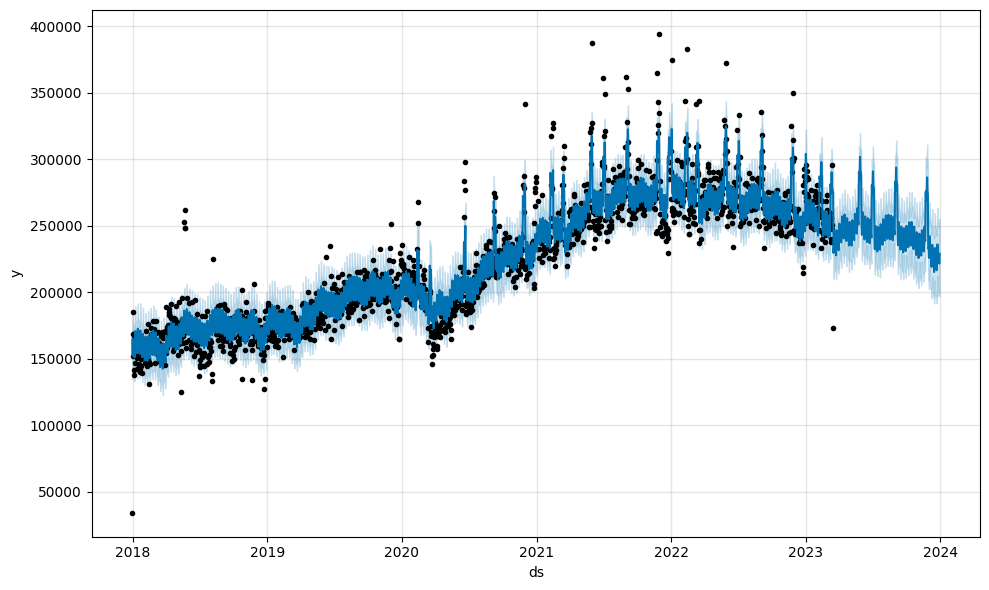

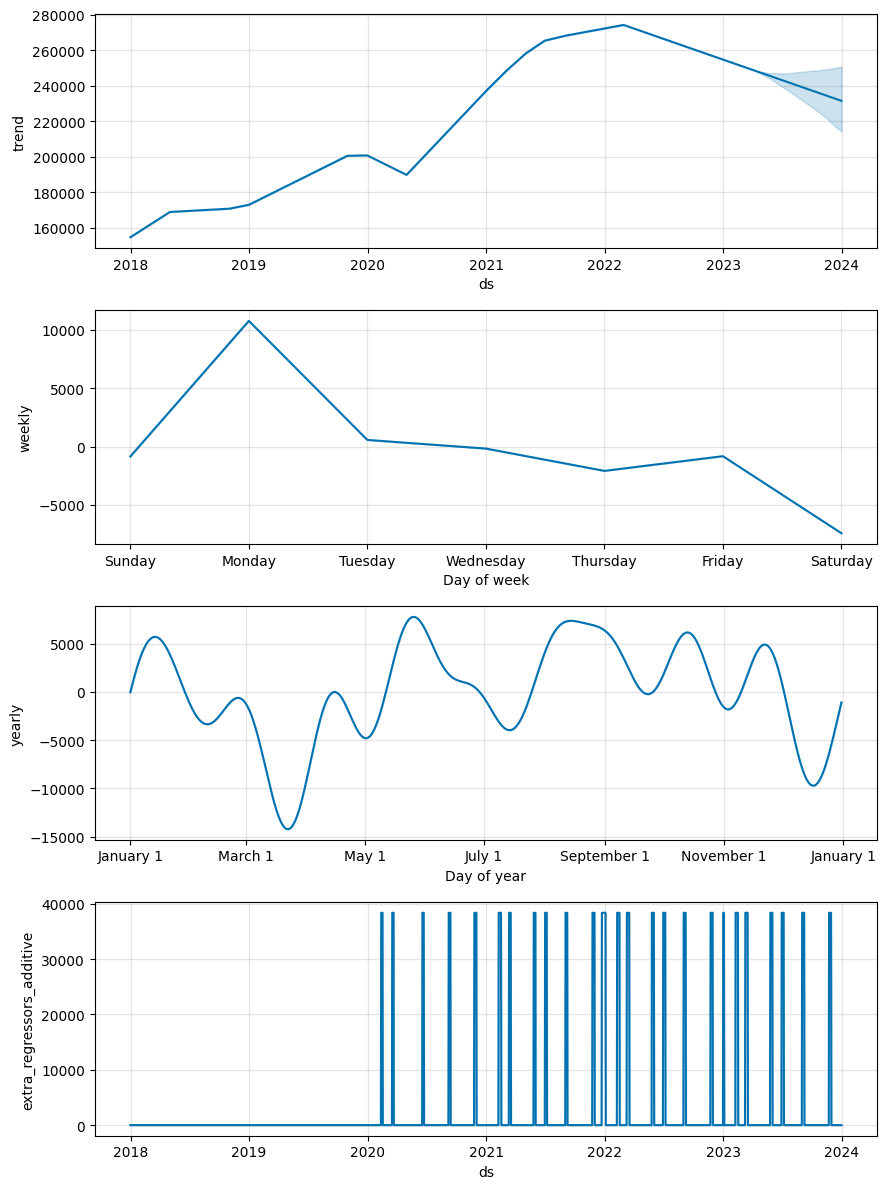

In [110]:
# Plot
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [111]:
# 2023 prediction ranges
print("LOWER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_lower))
print("MIDDLE:", sum(forecast[forecast.ds > '2022-12-31'].yhat))
print("UPPER:", sum(forecast[forecast.ds > '2022-12-31'].yhat_upper))

LOWER: 83231663.31721705
MIDDLE: 90490298.8917978
UPPER: 97906273.67893368
